# Survey Validation Data Challenge - Summer 2018

### Notebook 1 -- Generate a BGS/GAMA Parent Sample

The purpose of this notebook is to generate a BGS-like sample from existing GAMA observations.  We use GAMA targets and field centers, GAMA/SDSS spectroscopic redshifts, and Legacy Surveys photometry.

In [64]:
import os, sys, glob, time, subprocess, warnings
import numpy as np
import numpy.ma as ma
import healpy as hp
import matplotlib.pyplot as plt

In [52]:
from astropy.table import Table, hstack, Column
from astropy.io import fits
import fitsio

In [4]:
%matplotlib inline

In [5]:
print("Starting at {}".format(time.asctime()))
notebook_start_time = time.time()

Starting at Wed Jun 13 10:32:36 2018


### Define the top-level base (output) directory

We assume that *basedir* already has the appropriate GAMA catalogs downloaded.  See `${DESI_ROOT}/datachallenge/svdc-summer2018/GAMA-DR3/README` for details.

In [10]:
basedir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 'svdc-summer2018')
samplefile = os.path.join(basedir, 'bgs-gama-sample.fits')

#### Specify whether the output catalog should be overwritten.

If *overwrite_sample=True* the notebook will still run in order to generate the plots, which *will* be overwritten.

In [11]:
overwrite_sample = True

### Read the parent GAMA and Legacy Survey catalogs

For now, focus on the G02 field.

In [26]:
gamadir = os.path.join(basedir, 'GAMA-DR3')
ss = Table.read(os.path.join(gamadir, 'SpecObj.fits'))
kk = Table.read(os.path.join(gamadir, 'kcorr_model_z01.fits'))
gg = Table.read(os.path.join(gamadir, 'GaussFitSimple.fits'))
gg = gg[gg['IS_BEST']]
print(len(kk), len(ss), len(gg))

121672 160026 155117


In [27]:
len(np.unique(gg['CATAID']))

155117

In [21]:
#np.sum(np.in1d(kk['CATAID'], ss['CATAID'])), len(ss)

(121672, 160026)

In [106]:
def read_all_gama(H0=70, Om0=0.3):
    """Read all the objects in GAMA/DR3."""
    from astropy.table import join
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Spectroscopic redshifts
        specobjfile = os.path.join(gamadir, 'SpecObj.fits')
        specobj = Table.read(specobjfile)
        print('Read {} objects from {}'.format(len(specobj), specobjfile))
    
        photfile = os.path.join(gamadir, 'InputCatA.fits')
        phot = Table.read(photfile)
        print('Read {} objects from {}'.format(len(phot), photfile))
    
        kcorrfile = os.path.join(gamadir, 'kcorr_model_z01.fits')
        kcorr = Table(fitsio.read(kcorrfile, columns=['CATAID', 'KCORR_U', 'KCORR_G', 
                                                      'KCORR_R', 'KCORR_I', 'KCORR_Z'], ext=1))
        print('Read {} objects from {}'.format(len(kcorr), kcorrfile))
        
        # Emission lines
        gaussfitfile = os.path.join(gamadir, 'GaussFitSimple.fits')
        gg = fitsio.FITS(gaussfitfile)
        these = gg[1].where('is_best')
        gaussfit = Table(gg[1][these])
        gaussfit = gaussfit[['CATAID', 'HB_EW']]
        print('Read {} (unique) objects from {}'.format(len(gaussfit), gaussfitfile))

        # Join all the catalogs
        allgama = join(specobj, kcorr, join_type='left', keys='CATAID')
        allgama = join(allgama, phot, join_type='left', keys='CATAID')
        allgama = join(allgama, gaussfit, join_type='left', keys='CATAID')
        
    return allgama

allgama = read_all_gama()

Read 160026 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/GAMA-DR3/SpecObj.fits
Read 1831071 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/GAMA-DR3/InputCatA.fits
Read 121672 objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/GAMA-DR3/kcorr_model_z01.fits
Read 155117 (unique) objects from /Users/ioannis/work/desi/datachallenge/svdc-summer2018/GAMA-DR3/GaussFitSimple.fits


In [107]:
# Get absolute magnitudes
from astropy.cosmology import FlatLambdaCDM
H0 = 70
Om0 = 0.3
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

for band in ('U', 'G', 'R', 'I', 'Z'):
    allgama.add_column(Column(name='MABS_{}'.format(band), dtype='f4', length=len(allgama)))

# Require good, positive redshifts, good photometry, and good K-corrections
redshift = ma.getdata(allgama['Z'])
good = np.isfinite(redshift) * (redshift > 0)

for band in ('U', 'G', 'R','I', 'Z'):
    good *= np.isfinite(ma.getdata(allgama['MODELMAG_{}'.format(band)]))
    good *= np.isfinite(ma.getdata(allgama['KCORR_{}'.format(band)]))

DM = cosmo.distmod(redshift[good]).value

#D_L = cosmo.luminosity_distance(redshift[good]).value # Mpc 
#DM = 5. * np.log10(1e5 * D_L)
    
for band in ('U', 'G', 'R', 'I', 'Z'):
    kcorr = ma.getdata(allgama['KCORR_{}'.format(band)][good])
    mag = ma.getdata(allgama['MODELMAG_{}'.format(band)][good])
    allgama['MABS_{}'.format(band)][good] = mag - kcorr - DM

(0, 1)

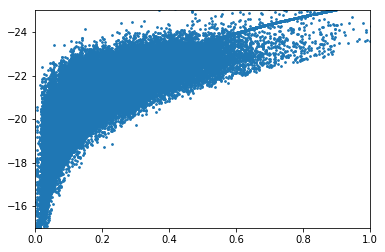

In [113]:
plt.scatter(allgama['Z'], allgama['MABS_R'], s=3)
plt.ylim(-15, -25)
plt.xlim(0, 1)

In [92]:
goodphot = np.ones(len(allgama)).astype(bool)
[goodphot * ma.getdata(allgama['MODELMAG_{}'.format(band)]) ]

goodkcorr = np.ones(len(allgama)).astype(bool)
[goodkcorr * ma.getdata(allgama['KCORR{}'.format(band)]) for bb in ('U', 'G', 'R','I', 'Z')]



['CATAID',
 'GAMA_NAME',
 'IC_FLAG',
 'N_SPEC',
 'N_GAMA_SPEC',
 'DIST',
 'SPECID',
 'SURVEY',
 'SURVEY_CODE',
 'RA_1',
 'DEC_1',
 'WMIN',
 'WMAX',
 'Z',
 'NQ',
 'PROB',
 'FILENAME',
 'URL',
 'URL_IMG',
 'OBJID',
 'RA_2',
 'DEC_2',
 'FLAGS',
 'PRIMTARGET',
 'TYPE',
 'PSFMAG_R',
 'FIBERMAG_R',
 'FLAGS_R',
 'EXTINCTION_R',
 'PETRORAD_R',
 'PETROR90_R',
 'PETROR50_R',
 'PETROMAG_G',
 'PETROMAG_R',
 'PETROMAG_I',
 'MODELMAG_U',
 'MODELMAG_G',
 'MODELMAG_R',
 'MODELMAG_I',
 'MODELMAG_Z',
 'STATUS',
 'RUN',
 'MASK_IC_10',
 'MASK_IC_12',
 'MASK_SATUR',
 'EXCEPTION_FLAG',
 'HB_EW',
 'MABS_U',
 'MABS_G',
 'MABS_R',
 'MABS_ I',
 'MABS_Z']

In [51]:
bb = join(ss, gg, join_type='left', keys='CATAID')
bb

CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA,DEC,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG,HB_EW
,,,,,arcsec,,,,deg,deg,A,A,,,,,,,
int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92,float32
6802,GAMAJ113601.43+004315.3,4104,1,1,0.07,G12_Y3_017_187,GAMA,5,174.006,0.72093,3727.71,8857.67,0.05054,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_187.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_187.png,5.2033396
6806,GAMAJ113605.47+004221.3,4104,1,1,0.07,G12_Y1_AN1_238,GAMA,5,174.02279,0.70594,3727.79,8856.73,0.33124,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_238.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_238.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_238.png,1.9093292
6808,GAMAJ113624.17+003932.1,4104,1,1,0.08,G12_Y1_AN1_235,GAMA,5,174.10071,0.65891,3727.79,8856.73,0.22936,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_235.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_235.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_235.png,-0.4348617
6810,GAMAJ113626.18+004814.0,4104,1,1,0.05,G12_Y2_041_164,GAMA,5,174.10908,0.8039,3727.91,8858.93,0.3263,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y2_041_164.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y2_041_164.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y2_041_164.png,0.20586862
6813,GAMAJ113615.31+003840.3,4104,1,1,0.05,G12_Y3_017_177,GAMA,5,174.06383,0.64454,3727.71,8857.67,0.48457,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_177.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_177.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_177.png,1.0169848
6816,GAMAJ113604.55+003956.8,4104,1,1,0.04,G12_Y3_017_182,GAMA,5,174.01896,0.6658,3727.71,8857.67,0.07641,4,0.986,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_182.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_017_182.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_017_182.png,3.4364512
6820,GAMAJ113608.43+004721.4,4104,3,3,0.05,G12_Y3_033_174,GAMA,5,174.03512,0.78928,3726.83,8857.89,0.4141,4,0.999,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_033_174.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y3_033_174.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y3_033_174.png,0.36218727
6821,GAMAJ113636.75+004855.5,4104,1,1,0.11,G12_Y1_AN1_254,GAMA,5,174.15312,0.81543,3727.79,8856.73,0.00382,4,0.998,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_254.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G12_Y1_AN1_254.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/png/G12_Y1_AN1_254.png,218.79057


In [13]:
def read_legacysurvey_gama(faintcut=20, overwrite=False):
    """Read the GAMA/DR3 catalog and select the G02 field.
    
    """
    gamadir = os.path.join(basedir, 'GAMA-DR3')
    truthdir = os.path.join(os.getenv('DESI_ROOT'), 'target', 'analysis', 'truth')
    
    def select_G02(cat, phot=None, return_index=False, faintcut=20):
        """Simple function to select galaxies in the G02 field where it 
        is complete.  See Table 1 in https://arxiv.org/pdf/1506.08222.pdf
        
        """
        cut = ( (cat['RA'] > 30) * (cat['RA'] < 39) * 
                (cat['DEC'] >= -6) * (cat['DEC'] <= -4)
              )
        if phot:
            cut = ( cut * (cat['NQ'] >= 3) * #(cat['Z'] < 1) * 
                    (phot['FLUX_R'] > 10**((22.5 - faintcut) / 2.5)) 
                  )
            print('Selecting {} objects in the G02 field with NQ>=3 and r<{:.1f}.'.format(
                np.sum(cut), faintcut))
        else:
            print('Selecting {} objects in the G02 field.'.format(np.sum(cut)))
        
        outcat = cat[cut]
        if return_index:
            return cut
        else:
            return outcat
    
    def read_all_gama():
        """Read all the objects in GAMA/DR3."""
        gamafile = os.path.join(gamadir, 'SpecObj.fits')
        allgama = Table.read(gamafile)
        print('Read {} objects from {}'.format(len(allgama), gamafile))
        gama = select_G02(allgama)
        return allgama, gama

    def read_legacysurvey(faintcut=20):
        """Read the GAMA/DR3 catalog matched to LegacySurvey/DR5."""
        gamafile = os.path.join(truthdir, 'dr5.0', 'trimmed', 'GAMA-DR3-SpecObj-trim.fits')
        alllsgama = Table.read(gamafile)
        print('Read {} objects from {}'.format(len(alllsgama), gamafile))
        
        lsfile = os.path.join(truthdir, 'dr5.0', 'trimmed', 'decals-dr5.0-GAMA-DR3-SpecObj-trim.fits')
        allls = Table.read(lsfile)
        print('Read {} objects from {}'.format(len(allls), lsfile))
        
        # Trim to the G02 field and join the two catalogs.
        indx = select_G02(alllsgama, phot=allls, return_index=True, faintcut=faintcut)
        lsgama = hstack( (allls[indx], alllsgama[indx]) )
        lsgama.rename_column('RA_1', 'RA')
        lsgama.rename_column('DEC_1', 'DEC')
        lsgama.rename_column('RA_2', 'RA_GAMA')
        lsgama.rename_column('DEC_2', 'DEC_GAMA')
        
        return lsgama
        
    def get_rmag(cat):
        return 22.5 - 2.5 * np.log10(cat['FLUX_R'] / cat['MW_TRANSMISSION_R'])
        
    allgama, gama = read_all_gama()
    lsgama = read_legacysurvey(faintcut=faintcut)
    
    if overwrite:
        print('Writing {} GAMA/BGS targets to {}'.format(len(lsgama), samplefile))
        lsgama.write(samplefile, overwrite=overwrite)
    
    allgama_G02 = allgama[(allgama['RA'] > 30) * (allgama['RA'] < 39)]
    
    # Visualize the position of the G02 field.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.scatter(allgama['RA'], allgama['DEC'], s=1)
    ax1.set_title('All GAMA Fields (N={})'.format(len(allgama)))
    
    ax2.scatter(allgama_G02['RA'], allgama_G02['DEC'], s=1, label='All Objects (N={})'.format(len(allgama_G02)))
    ax2.scatter(gama['RA'], gama['DEC'], s=1, label='Complete Region (N={})'.format(len(gama)))
    ax2.set_xlim(29, 40)
    ax2.set_ylim(-11, -2)
    ax2.set_title('GAMA/G02 Field')
    ax2.legend(loc='upper left', ncol=1, markerscale=5)
    
    ax3.scatter(lsgama['RA'], lsgama['DEC'], s=1, alpha=0.5, 
                label='NQ>=3, r<{:.1f} (N={})'.format(faintcut, len(lsgama)))
    ax3.set_xlim(29, 40)
    ax3.set_ylim(-7, -3)
    ax3.set_title('GAMA/G02 Field')
    ax3.legend(loc='upper left', markerscale=5)

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        
    fig.subplots_adjust(wspace=0.25)
    if overwrite:
        fig.savefig(os.path.join(basedir, 'qa-sv-bgs-all.png'))
    
    # Visualize the magnitude and redshift distributions.
    rmag = get_rmag(lsgama)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.hist(lsgama['Z'], bins=50)
    ax1.set_xlabel('GAMA Redshift')
    ax1.set_ylabel('Number of Objects')
    
    ax2.hist(rmag, bins=60)
    ax2.set_xlabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax2.set_ylabel('Number of Objects')
    ax2.axvline(x=faintcut, color='k', ls='--')
    
    ax3.scatter(lsgama['Z'], rmag, s=1)
    ax3.set_xlabel('GAMA Redshift')
    ax3.set_ylabel(r'$r_{cor}$ (DECaLS, AB mag)')
    ax3.set_ylim(12, 20)
    ax3.axhline(y=faintcut, color='k', ls='--')
    
    fig.subplots_adjust(wspace=0.25)
    if overwrite:
        fig.savefig(os.path.join(basedir, 'qa-sv-bgs.png'))
    
    return lsgama

Read 160026 objects from /Users/ioannis/work/desi/target/analysis/truth/parent/GAMA-DR3-SpecObj.fits
Selecting 19695 objects in the G02 field.
Read 157343 objects from /Users/ioannis/work/desi/target/analysis/truth/dr5.0/trimmed/GAMA-DR3-SpecObj-trim.fits
Read 157343 objects from /Users/ioannis/work/desi/target/analysis/truth/dr5.0/trimmed/decals-dr5.0-GAMA-DR3-SpecObj-trim.fits
Selecting 16010 objects in the G02 field with NQ>=3 and r<19.7.
Writing 16010 GAMA/BGS targets to /Users/ioannis/work/desi/survey-validation/sv-bgs-sample.fits


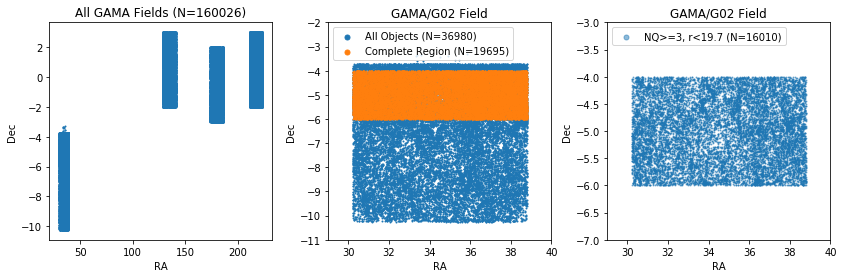

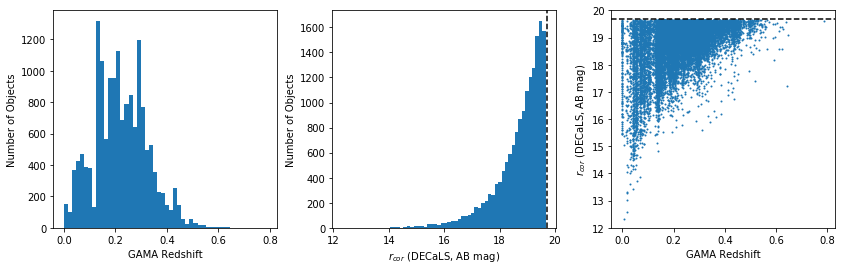

In [11]:
gama = read_legacysurvey_gama(faintcut=19.7, overwrite=overwrite_sample)

In [12]:
gama[:2]

RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,DCHISQ [5],EBV,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_Y,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_U,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_I,FLUX_IVAR_Z,FLUX_IVAR_Y,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_U,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_I,MW_TRANSMISSION_Z,MW_TRANSMISSION_Y,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,NOBS_U,NOBS_G,NOBS_R,NOBS_I,NOBS_Z,NOBS_Y,NOBS_W1,NOBS_W2,NOBS_W3,NOBS_W4,RCHISQ_U,RCHISQ_G,RCHISQ_R,RCHISQ_I,RCHISQ_Z,RCHISQ_Y,RCHISQ_W1,RCHISQ_W2,RCHISQ_W3,RCHISQ_W4,FRACFLUX_U,FRACFLUX_G,FRACFLUX_R,FRACFLUX_I,FRACFLUX_Z,FRACFLUX_Y,FRACFLUX_W1,FRACFLUX_W2,FRACFLUX_W3,FRACFLUX_W4,FRACMASKED_U,FRACMASKED_G,FRACMASKED_R,FRACMASKED_I,FRACMASKED_Z,FRACMASKED_Y,FRACIN_U,FRACIN_G,FRACIN_R,FRACIN_I,FRACIN_Z,FRACIN_Y,ANYMASK_U,ANYMASK_G,ANYMASK_R,ANYMASK_I,ANYMASK_Z,ANYMASK_Y,ALLMASK_U,ALLMASK_G,ALLMASK_R,ALLMASK_I,ALLMASK_Z,ALLMASK_Y,WISEMASK_W1,WISEMASK_W2,PSFSIZE_U,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFSIZE_Y,PSFDEPTH_U,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_I,PSFDEPTH_Z,PSFDEPTH_Y,GALDEPTH_U,GALDEPTH_G,GALDEPTH_R,GALDEPTH_I,GALDEPTH_Z,GALDEPTH_Y,WISE_COADD_ID,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_R_IVAR,SHAPEDEV_E1,SHAPEDEV_E1_IVAR,SHAPEDEV_E2,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_R_IVAR,SHAPEEXP_E1,SHAPEEXP_E1_IVAR,SHAPEEXP_E2,SHAPEEXP_E2_IVAR,CATAID,GAMA_NAME,IC_FLAG,N_SPEC,N_GAMA_SPEC,DIST,SPECID,SURVEY,SURVEY_CODE,RA_GAMA,DEC_GAMA,WMIN,WMAX,Z,NQ,PROB,FILENAME,URL,URL_IMG
int32,int32,bytes8,int32,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes23,int16,int16,int16,float32,bytes33,bytes9,int16,float64,float64,float32,float64,float32,int16,float32,bytes67,bytes88,bytes92
5000,295990,0347m060,3740,COMP,34.890341079425994,-5.999691682110999,4570791000000.0,4816965000000.0,380718.56 .. 657301.0,0.025039164,0.0,14.195835,40.030807,0.0,77.26228,0.0,74.38492,53.769085,145.09949,17.496735,0.0,575.5074,173.69781,0.0,44.052402,0.0,1.4482807,0.3196188,0.0014982224,3.4697245e-05,0.9119844,0.9285593,0.9512969,0.96395123,0.97245836,0.9757607,0.99576557,0.9973974,0.99944437,0.99979013,0,8,9,0,10,0,83,84,24,24,0.0,2.906153,1.3095417,0.0,1.7787125,0.0,2.4887478,0.7378041,0.5677778,0.103369206,0.0,5.6221965e-05,7.64634e-05,0.0,1.7972214e-05,0.0,0.02481547,0.026488105,0.2887721,21.924564,0.0,0.0050085993,0.0035609463,0.0,0.061266117,0.0,0.0,1.0148772,1.0301899,0.0,0.9659238,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,1.4427451,1.3211417,0.0,1.0914309,0.0,0.0,4988.781,1655.8958,0.0,459.8917,0.0,0.0,3043.762,969.0382,0.0,234.25917,0.0,0349m061,0.13350707,2120865.2,0.32979923,36816.79,-0.07739693,2620.0586,-0.6948547,1137.4686,1.9406624,100692.01,0.018664878,267119.28,0.075529814,579053.75,1075400,GAMAJ021933.67-055958.8,8192,1,1,0.0,G02_Y3_018_362,GAMA,5,34.89033,-5.99968,3727.0,8858.05,0.25562,4,1.0,/GAMA/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_018_362.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/G02_Y3_018_362.fit,http://www.gama-survey.org/dr3/data/spectra/gama/reduced_27/1d/pn